In [9]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import pandas as pd
import json

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import seaborn as sns
import catboost as cb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
# from paramsearch import paramsearch
# from itertools import product,chain
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

import eli5
from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import matplotlib.colors as clt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
# from tqdm import tqdm
from scipy.stats import kurtosis, skew

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from keras.layers import Dense
# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import zipfile
from keras.models import Sequential
# zf = zipfile.ZipFile('train.csv') # having First.csv zipped file.
# df = pd.read_csv(zf.open('First.csv'))
# zf.namelist()

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [10]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(X.ptp())
#     strain.append(X.var())
    strain.append(np.quantile(X, 0.01))
    strain.append(np.quantile(X, 0.05))
    zc=np.fft.fft(X)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    strain.append(realFFT.mean())
    strain.append(realFFT.std())
    strain.append(realFFT.max())
    strain.append(realFFT.min())
    strain.append(imagFFT.mean())
    strain.append(imagFFT.std())
    strain.append(imagFFT.max())
    strain.append(imagFFT.min())

    strain.append((X.rolling(10).std().dropna().values).mean())
    strain.append((X.rolling(10).mean().dropna().values).mean())
    strain.append((X.rolling(100).std().dropna().values).mean())
    strain.append((X.rolling(100).mean().dropna().values).mean())
    strain.append((X.rolling(1000).std().dropna().values).mean())
    strain.append((X.rolling(1000).mean().dropna().values).mean())
    strain.append((X.rolling(2).quantile(.01, interpolation='midpoint')).mean())
#     strain.append((X.rolling(2).quantile(.05, interpolation='midpoint')).mean())

#     X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#     X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#     X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#     X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#     X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#     strain.append(np.quantile((X.rolling(windows).std().dropna().values), 0.05))
#     X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
#     X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
#     X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#     X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
#     X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
    return pd.Series(strain)

# final.describe()
    

In [11]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#

In [12]:

X_train1 = pd.DataFrame()
y_train1= pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train1 = X_train1.append(ch, ignore_index=True)
    y_train1 = y_train1.append(pd.Series(df['time_to_failure'].values[-1]))

In [13]:
X_train1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,202.0,-8.0,-2.0,12.0,2349.811482,732617.0,-20121.154171,-1.697723e-15,1399.854635,23432.719433,-23432.719433,3.507118,4.884088,4.050450,4.883864,4.288590,4.883418,4.884106
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,335.0,-11.0,-2.0,5.0,2566.032248,708865.0,-31056.675076,1.843243e-15,1810.312266,27236.180586,-27236.180586,3.761435,4.725732,4.436359,4.725623,4.843486,4.724876,4.725765
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,246.0,-15.0,-3.0,5.0,2683.549049,735959.0,-27654.557067,4.850638e-16,1921.220576,30073.497066,-30073.497066,4.080841,4.906229,4.917334,4.906088,5.423013,4.905840,4.906399
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,396.0,-12.0,-2.0,5.0,2685.788525,735336.0,-25622.393604,-1.067140e-15,1891.826366,27380.321471,-27380.321471,3.788192,4.902291,4.533343,4.901946,4.939280,4.901486,4.902239
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,271.0,-15.0,-2.0,12.0,2761.715771,736308.0,-26271.075117,-1.455192e-16,1995.742969,27503.045280,-27503.045280,3.835604,4.908728,4.761149,4.909175,5.121868,4.910196,4.908676


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, train_size=0.5, random_state=1234)

In [15]:
# train_label=Xtrain1.columns

# params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'ctr_border_count':[50,5,10,20,100,200],
#           'thread_count':4}

NameError: name 'Xtrain1' is not defined

In [ ]:
# def crossvaltest(params,X_train,train_label,cat_dims=None,n_splits=3):
#     kf = KFold(n_splits=n_splits,shuffle=True) 
#     res = []
#     for train_index, test_index in kf.split(X_train):
#         train = train_set.iloc[train_index,:]
#         test = train_set.iloc[test_index,:]

#         labels = train_label.ix[train_index]
#         test_labels = train_label.ix[test_index]

#         clf = cb.CatBoostRegressor(**params)
#         clf.fit(train, np.ravel(labels), cat_features=cat_dims)

#         res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
#     return np.mean(res)

In [16]:
# this function runs grid search on several parameters
# def catboost_param_tune(params,X_train,train_label,cat_dims=None,n_splits=3):
#     ps = paramsearch(params)
#     # search 'border_count', 'l2_leaf_reg' etc. individually 
#     #   but 'iterations','learning_rate' together
#     for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
#                       ps.grid_search(['l2_leaf_reg']),
#                       ps.grid_search(['iterations','learning_rate']),
#                       ps.grid_search(['depth'])):
#         res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
#         # save the crossvalidation result so that future iterations can reuse the best parameters
#         ps.register_result(res,prms)
#         print(res,prms,s'best:',ps.bestscore(),ps.bestparam())
#     return ps.bestparam()

# bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)

In [17]:
# train_pool = Pool(X_train_scaled, y_binary)
model=CatBoostRegressor(iterations=10000, depth=3, learning_rate=0.1, loss_function='MAE',boosting_type='Plain')
model.fit(X_train, y_train, silent=True)


In [18]:
#1.56
model.best_score_

{'learn': {'MAE': 1.213729961877429}}

In [19]:
#2.2674
y_pred=(model.predict(X_test))
mean_absolute_error(y_test, y_pred, sample_weight=None)

2.1469322059943

In [20]:
# submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [21]:
# X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [22]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

# prepare test data
for seg_id in submission.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

# X_test = scaler.transform(X_test)

In [23]:
# X_test.shape

In [24]:
# for seg_id in X_test.index:
#     seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
#     x = seg['acoustic_data'].values
    
#     X_test.loc[seg_id, 'ave'] = x.mean()
#     X_test.loc[seg_id, 'std'] = x.std()
#     X_test.loc[seg_id, 'max'] = x.max()
#     X_test.loc[seg_id, 'min'] = x.min()
#     X_test.loc[seg_id, 'cor'] = x.ptp()
#     X_test.loc[seg_id, 'var'] = x.var()
#     X_test.loc[seg_id, '25%'] = pd.Series(x).quantile(.25)
#     X_test.loc[seg_id, '50%'] = pd.Series(x).quantile(.5)
#     X_test.loc[seg_id, '75%'] = pd.Series(x).quantile(.75)
#     X_test['rol_2']=X_test['ave'].rolling(2).mean()
#     X_test['rol_3']=X_test['ave'].rolling(3).mean()
#     X_test['rol_4']=X_test['ave'].rolling(4).mean()
#     X_test['rol_5']=X_test['ave'].rolling(5).mean()
#     X_test['rol_2']=X_test['rol_2'].fillna(X_test['rol_2'].dropna().mean())
#     X_test['rol_3']=X_test['rol_2'].fillna(X_test['rol_3'].dropna().mean())
#     X_test['rol_4']=X_test['rol_4'].fillna(X_test['rol_4'].dropna().mean())
#     X_test['rol_5']=X_test['rol_5'].fillna(X_test['rol_5'].dropna().mean())
#     X_test['rol_std_2']=X_test['ave'].rolling(2).std()
#     X_test['rol_std_3']=X_test['ave'].rolling(3).std()
#     X_test['rol_std_4']=X_test['ave'].rolling(4).std()
#     X_test['rol_std_5']=X_test['ave'].rolling(5).std()
#     X_test['rol_std_2']=X_test['rol_std_2'].fillna(X_test['rol_std_2'].dropna().mean())
#     X_test['rol_std_3']=X_test['rol_std_3'].fillna(X_test['rol_std_3'].dropna().mean())
#     X_test['rol_std_4']=X_test['rol_std_4'].fillna(X_test['rol_std_4'].dropna().mean())
#     X_test['rol_std_5']=X_test['rol_std_5'].fillna(X_test['rol_std_5'].dropna().mean())

In [25]:
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_hat = model.predict(X_test)

In [26]:
# X_test_scaled = scaler.transform(X_test)
# submission['time_to_failure'] = model.predict(X_test_scaled)


In [28]:
submission['time_to_failure'] = y_hat
submission.to_csv('submission.csv')

In [29]:
submission.to_csv('../submission.csv')

In [30]:
X_train1.columns = ['mean','std', 'min', 'max', 'kurt', 'skew','ptp','q.01','q.05','Rmean','Rstd','Rmax','Rmin','Imean','Istd','Imax','Imin','rol_std_10','rol_mean_10','rol_std_100','rol_mean_100','rol_std_1000','rol_mean_1000','rol_q.04']


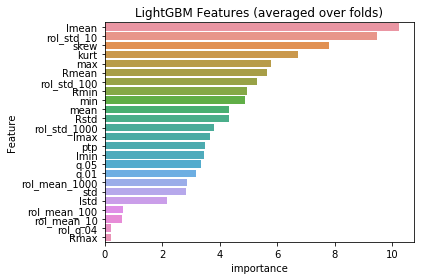

In [31]:
fold_importance_df=pd.DataFrame()
fold_importance_df['Feature']=X_train1.columns
feature_importance_df=pd.DataFrame()
fold_importance_df["importance"]=model.feature_importances_[:len(X_train1.columns)]
feature_importance_df=pd.concat([feature_importance_df, fold_importance_df], axis=0)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [32]:
# pd.options.display.precision = 15

# submission.head()